In [77]:
import pandas as pd
import numpy as np
import os # doesnt have to be installed with pip

import seaborn as sns

In [615]:
df = pd.read_csv('data/Kickstarter_preprocessed.csv')

In [616]:
df.head()

,Unnamed: 0,backers_count,blurb,converted_pledged_amount,country,created_at,currency,currency_symbol,currency_trailing_code,current_currency,...,text_color,link_background_color,link_text_color,link_text,link_url,show_feature_image,background_image_opacity,should_show_feature_image_section,feature_image_attributes,background_image_attributes
0,0,1,"Larping, storytelling that comes to life in a ...",1,US,1430275012,USD,$,True,USD,...,NaN,NaN,NaN,NaN,NaN,0.0,0.8,1.0,{'default': 'https://ksr-ugc.imgix.net/assets/...,NaN
1,1,18,A film dedicated to an AAF Pilot's struggle to...,1571,US,1406957966,USD,$,True,USD,...,NaN,NaN,NaN,NaN,NaN,0.0,0.8,1.0,{'default': 'https://ksr-ugc.imgix.net/assets/...,NaN
2,2,2,Re-creating the visual of flight from dream to...,2,US,1405979448,USD,$,True,USD,...,NaN,NaN,NaN,NaN,NaN,0.0,0.8,1.0,{'default': 'https://ksr-ugc.imgix.net/assets/...,NaN
3,3,0,Journaling in pursuit of advocacy for single m...,0,US,1464120865,USD,$,True,USD,...,NaN,NaN,NaN,NaN,NaN,0.0,0.8,1.0,{'default': 'https://ksr-ugc.imgix.net/assets/...,NaN
4,4,1,"Fun, addicting, innovative, beautiful, possibl...",5,US,1347473433,USD,$,True,USD,...,NaN,NaN,NaN,NaN,NaN,0.0,0.8,1.0,{'default': 'https://ksr-ugc.imgix.net/assets/...,NaN


In [500]:
# delete first column
df.drop(['Unnamed: 0'],axis=1,inplace=True);

# rename some columns
df.rename(columns={'name_category':'category_sub','slug_category':'category','blurb':'description'},inplace=True)

df.category = df.category.apply(lambda x: x.split('/')[0])

In [501]:
#staff_pick -> Vorsicht!
## features to add
# subcategory
# category
# region, state, blub
df['desription'] = df['description'].apply(lambda x: len(str(x).split()))
df = df.eval('usd_goal = static_usd_rate * goal')
df['duration'] = df['deadline'] - df['launched_at']


In [502]:
# create function for format change
# we could also use lambda x: datetime.utcfromtimestamp(x)
from datetime import datetime

def chg_date(x):
    return datetime.utcfromtimestamp(x)

# apply on dataframe

time_col = ['created_at','deadline','state_changed_at','launched_at']
df[time_col] = df[time_col].applymap(chg_date)

In [504]:
######### First feature engineering

# Replace short description of project with length of description
df['description'] = df['description'].apply(lambda x: len(str(x).split()))

# convert all goals into USD
df = df.eval('usd_goal = static_usd_rate * goal')

# create duration of project
df['duration'] = df['deadline'] - df['launched_at']
df['duration_days']=df['duration'].dt.days

# create year and month in which project ist started
df['start_month']= df['launched_at'].dt.month
df['start_year']= df['launched_at'].dt.year

# split text in column category, keep only left part of string --> main category
df.category = df.category.apply(lambda x: x.split('/')[0])

# change to lower case string
df.category_sub = df.category_sub.str.lower()

In [505]:
pledged_per_year_month = df.groupby(['start_year','start_month']).sum().usd_pledged.reset_index()
pledged_per_year = df.groupby(['start_year']).sum()

pledged_per_year.loc[2009,'usd_pledged']

for i in range(0,pledged_per_year_month.shape[0]):
    pledged_per_year_month.loc[i,'usd_pledged'] = pledged_per_year_month.loc[i,'usd_pledged'] / pledged_per_year.loc[pledged_per_year_month.loc[i,'start_year'],'usd_pledged']

In [596]:
pledged_per_year.usd_pledged.reset_index().loc[:,'start_year']
pledged_per_year.usd_pledged.reset_index().loc[:,'usd_pledged']

0     8.153531e+05
1     6.453170e+06
2     2.318343e+07
3     7.743207e+07
4     1.907555e+08
5     2.571229e+08
6     3.591758e+08
7     3.133357e+08
8     4.364007e+08
9     8.615519e+08
10    1.710914e+08
Name: usd_pledged, dtype: float64

Text(0.5, 1.0, 'Money Pledged by Kickstarter Users')

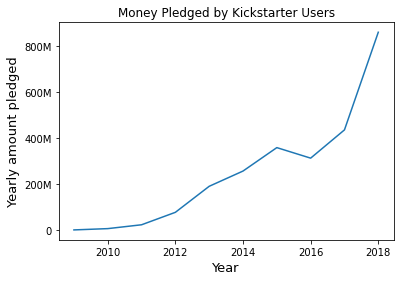

In [629]:
plt.plot(pledged_per_year.usd_pledged.reset_index().loc[0:9,'start_year'],pledged_per_year.usd_pledged.reset_index().loc[0:9,'usd_pledged'])
plt.yticks([0,200000000,400000000,600000000,800000000],['0','200M','400M','600M','800M'])
plt.ylabel('Yearly amount pledged', size=13)
plt.xlabel('Year', size=13)
plt.title('Money Pledged by Kickstarter Users')

In [559]:
durations_list = sorted(list(df.duration_days.unique()))
duration_counts = df.duration_days.value_counts()

countries_list = list(df.country.unique())

categories_list = list(df.category.unique())

description_length = list(df.description.unique())

In [584]:
success_per_duration_day = [len(df.query('state in ["successful"] & duration_days==@i'))/len(df.query('state in ["successful","failed"] & duration_days==@i')) for i in durations_list]

success_per_country = [[round(len(df.query('state in ["successful"] & country==@i'))/len(df.query('state in ["successful","failed"] & country==@i')),5), i] for i in countries_list]
success_per_country = np.array(sorted(success_per_country, key= lambda x: x[0]))

succes_per_category = [[len(df.query('state in ["successful"] & category==@i'))/len(df.query('state in ["successful","failed"] & category==@i')), i] for i in categories_list]
success_per_category = np.array(sorted(success_per_category, key= lambda x: x[0]))

success_per_description_length = [len(df.query('state in ["successful"] & description==@i'))/len(df.query('state in ["successful","failed"] & description==@i')) for i in description_length]

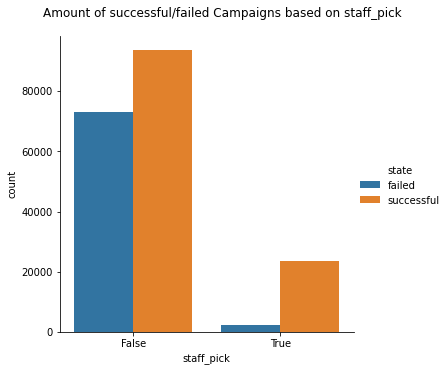

In [625]:
ax = sns.catplot(data=df.query('state in ["successful","failed"]'), x='staff_pick', hue='state', kind='count')
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle("Amount of successful/failed Campaigns based on staff_pick");

In [627]:
window_size = 2

rolling_avg = pd.Series(success_per_duration_day[0:])
windows = rolling_avg.rolling(windows_size)
moving_av = windows.mean()

moving_av_list = moving_av.tolist()
without_nans = moving_av_list[window_size - 1:]

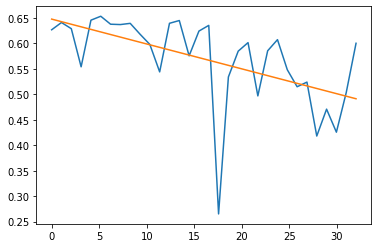

In [613]:
window_size = 2

rolling_avg = pd.Series(success_per_description_length[0:])
windows = rolling_avg.rolling(windows_size)
moving_av = windows.mean()

moving_av_list = moving_av.tolist()
without_nans = moving_av_list[window_size - 1:]

#success_per_description_length = success_per_description_length[:-1]
polyline = np.linspace(0,len(success_per_description_length), num=len(success_per_description_length))
plt.plot(polyline, success_per_description_length)

model = np.poly1d(np.polyfit(np.linspace(0,len(success_per_description_length),num=len(success_per_description_length)), success_per_description_length, 1))

#add fitted polynomial line to scatterplot

plt.plot(polyline, model(polyline))

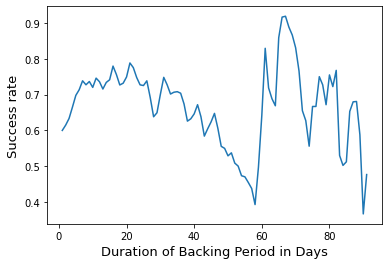

In [628]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(without_nans)), without_nans)
plt.xlabel('Duration of Backing Period in Days', size=13);
plt.ylabel('Success rate', size=13);

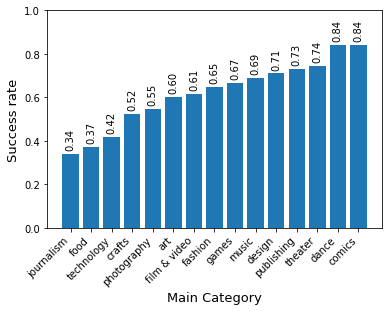

In [622]:
fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Success rate', size=13)
plt.xlabel('Main Category', size=13)
plt.ylim(0,1)
rec = ax.bar(success_per_category[:,1], height=success_per_category[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')

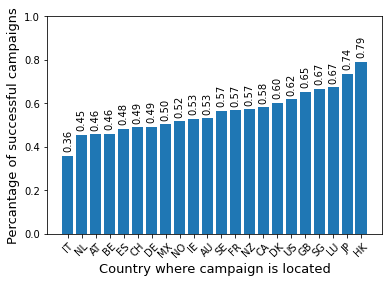

In [623]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
plt.xlabel('Country where campaign is located', size=13)
plt.ylabel('Percantage of successful campaigns', size=13)
plt.ylim(0,1)
rec = ax.bar(success_per_country[:,1], height=success_per_country[:,0].astype(float))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')


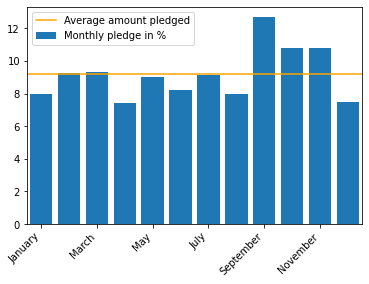

In [598]:
fig, ax = plt.subplots()
plt.xlim(-0.5,11.5)
plt.xticks([0,2,4,6,8,10],['January','March','May','July','September','November'],rotation=45,ha='right')
rec = ax.bar(x=range(0,12), height=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged*100, label='Monthly pledge in %')
ax.plot(np.linspace(-0.5,11.5,num=13),np.mean(pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged*100)*np.ones([13,1]), color='orange', label='Average amount pledged')
plt.legend()


from scipy.interpolate import interp1d
from scipy import interpolate

#tck = interpolate.splrep(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, s=0)
#xnew = np.linspace(0, 11, num=100, endpoint=True)
#ynew = interpolate.splev(xnew, tck, der=0)

#f2 = interp1d(x=range(0,12), y=pledged_per_year_month.groupby('start_month').mean().reset_index().usd_pledged, kind='cubic')
#plt.plot(np.linspace(0, 10, num=100, endpoint=True), f2(np.linspace(0, 10, num=100, endpoint=True)))

#plt.plot(xnew,ynew)

